In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/job_exam/facial-expression-classification

/content/drive/MyDrive/job_exam/facial-expression-classification


In [ ]:
!pip install opendatasets
!pip install seaborn
!pip install tensorflow_addons
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import the packages.
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Activation,Resizing,Rescaling
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow_addons as tfa 
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Download the data
#od.download_kaggle_dataset('https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset'
                           #,data_dir='./data')

In [ ]:
train_images_dir = './data/facial-expression-dataset/train/train'
test_images_dir = './data/facial-expression-dataset/test/test'

In [ ]:
def create_dataframe(base_dir):
    index = 0
    df = pd.DataFrame(columns=['image_name','width','height','dim','target'])
    for target in os.listdir(base_dir):
        for image in os.listdir(base_dir+'/'+target):
            img = plt.imread(base_dir+'/'+target+'/'+image)
            df.loc[index]=[image,img.shape[1],img.shape[0],img.ndim,target]
            index+=1
    return df

In [ ]:
df_train_1 = create_dataframe(train_images_dir)
df_test_1 = create_dataframe(test_images_dir)

In [ ]:
# create dataframe for the data, for analysis
#df_train = create_dataframe(train_images_dir)
#df_test = create_dataframe(test_images_dir)
#df_train.to_csv('training_data.csv',index=False)
#df_test.to_csv('testing_data.csv',index=False)

df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('testing_data.csv')


In [ ]:
df_train.sample(frac=1).head()

,image_name,width,height,dim,target
1551,neutral/Training_8180262.jpg,48,48,2,neutral
3128,neutral/Training_32668083.jpg,48,48,2,neutral
17527,happy/Training_78954042.jpg,48,48,2,happy
25875,sad/Training_86465311.jpg,48,48,2,sad
2585,neutral/Training_25293667.jpg,48,48,2,neutral


# EDA

In [ ]:
# Checking the size of the data
print('Train set number of samples: %d'%len(df_train),
      '\nTest set number of samples: %d'%len(df_test))

Train set number of samples: 28709 
Test set number of samples: 7178


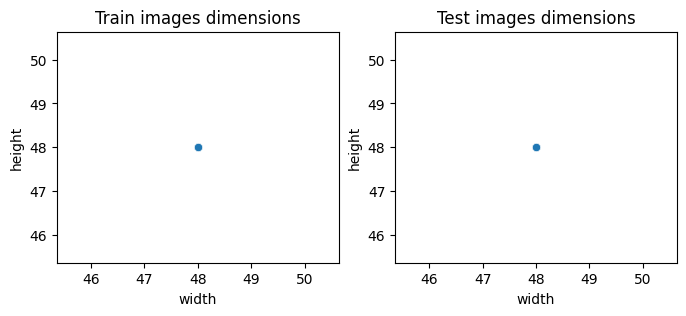

In [ ]:
# all images have the same width and height (48,48)
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(1,2,1)
ax.title.set_text('Train images dimensions')
sns.scatterplot(data=df_train,x='width',y='height')
ax = plt.subplot(1,2,2)
ax.title.set_text('Test images dimensions')
sns.scatterplot(data=df_test,x='width',y='height');

In [ ]:
# Checking the image number of dimensions
# the images have only 2 dim, which means it is grayscaled images.
print('Number of dimensions in the training images: %d'%df_train['dim'].unique())
print('Number of dimensions in the testing images: %d'%df_test['dim'].unique())

Number of dimensions in the training images: 2
Number of dimensions in the testing images: 2


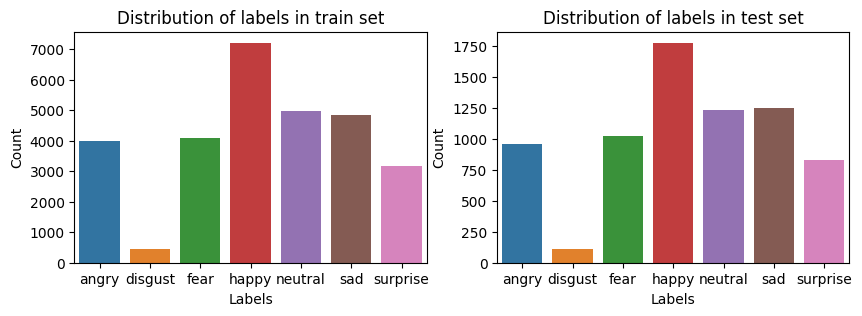

In [ ]:
train_target_count = df_train.groupby('target')['target'].count()
test_target_count = df_test.groupby('target')['target'].count()
plt.figure(figsize=(10,3))
# training set barplot
ax = plt.subplot(1,2,1)
ax.title.set_text('Distribution of labels in train set')
sns.barplot(x=list(train_target_count.index),y=list(train_target_count.values));
plt.xlabel('Labels')
plt.ylabel('Count');
#testing set barplot
ax = plt.subplot(1,2,2)
ax.title.set_text('Distribution of labels in test set')
sns.barplot(x=list(test_target_count.index),y=list(test_target_count.values));
plt.xlabel('Labels')
plt.ylabel('Count');
# we can see from the graph that we have imbalance classes in the training set,
#that we need to deal with or it will affect the performance.

In [ ]:
# display samples of each target class.
def gallery(df,base_dir):
    labels = df.target.unique()
    n_cols = 8
    n_rows = len(labels)+1
    index = 1
    plt.figure(figsize=(1.5*n_cols,1.2*n_rows))
    plt.subplots_adjust(top=1.6,right=1.2)
    for label in range(len(labels)):
        image_name = df[df.target == labels[label]].iloc[0:n_cols]['image_name']
        #print(image_name)
        for image in image_name:
            plt.subplot(n_rows,n_cols,index)

            img = plt.imread(base_dir+'/'+labels[label]+'/'+image)
            plt.imshow(img,cmap=plt.cm.gray)
            plt.axis('off')
            index+=1
            plt.title(labels[label])

        

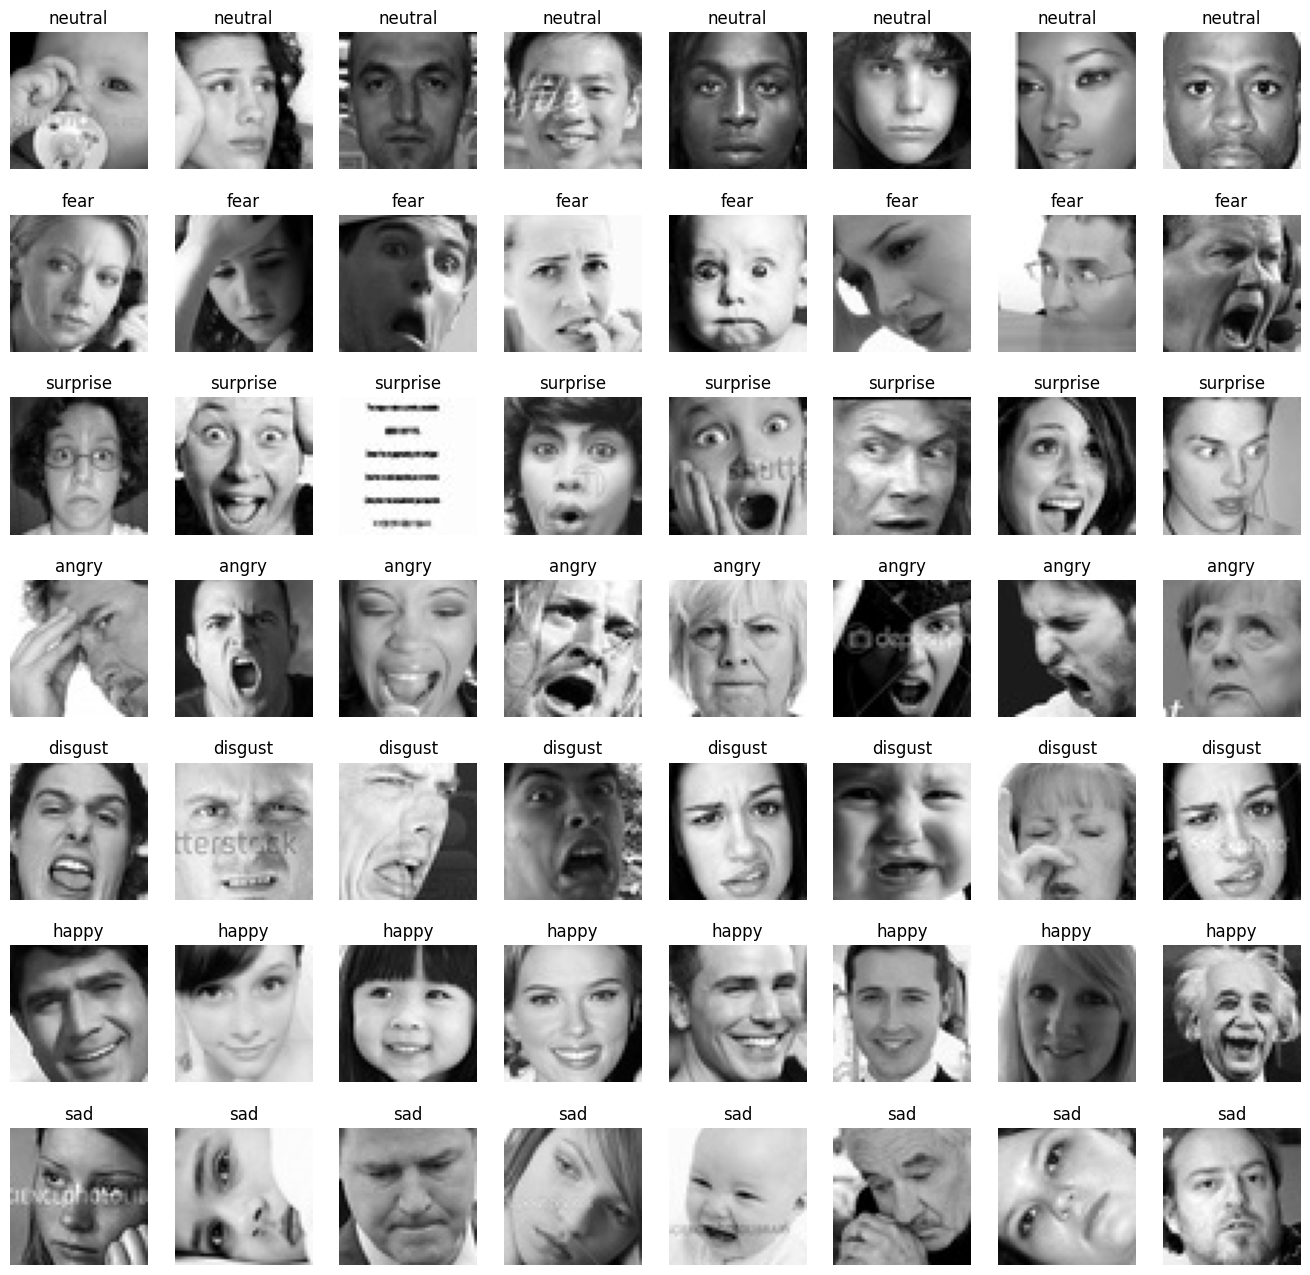

In [ ]:
# From the data visualization we can see the data contains irrelvent images as the image in the third row second column, different rotations, rotations and occlusions.
gallery(df_train,train_images_dir)

Assumptions:
- The Disgust class could be hard to train, because we have only 400 samples in the training set, even with the weights, it could be difficult to reduce the misclassification. 
 - Using a pre-trained model probably would not yield good performance, because The data's characteristics are different from the images in ImageNet, like the size and dimensions. 
 - The performance of training a network from scratch will not be very high for multiple reasons, the data is small, it contains noise and wrong targets (as in the image below), some occlusions hide parts of the features, and different angles and rotations.

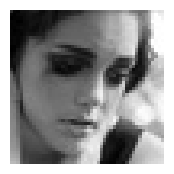

In [ ]:
fig = plt.figure(figsize=(2,2))
plt.imshow(plt.imread(train_images_dir+'/angry/Training_247656.jpg'),cmap=plt.cm.gray)
plt.axis('off');
# this image is in the angry class, however we can see that is should be in sad class.

# ML

I choose Deep learning since tradition ML algorithms requires feature extraction algorithms and feature engineering before it can be trained on the data, which consume time and require domain knowledge. In addition, as we have seen above, the images are not under controlled enviroments, which is usually a requirment for feature extraction algorithms. DL, in most cases learn better features and filters and thus gives better results under these conditions. 

- Since the data is imbalanced it is better to use some method to fix it. 
- There are different methods such as oversampling, undersampling, assigning weights. In this case I will use weights, because the difference between the minor and major classes is very large and if we do oversampling there is high chance of overfitting. Also the data is not large enough to do downsampling. 

In [ ]:
# calculating the weights
num_samples = len(df_train)
classes = df_train.target.unique()
weights = dict()
for c in classes:
    w = num_samples / (len(classes)*len(df_train[df_train['target'] == c]))
    weights[c] = round(w,2)
weights

{'neutral': 0.83,
 'fear': 1.0,
 'surprise': 1.29,
 'angry': 1.03,
 'disgust': 9.41,
 'happy': 0.57,
 'sad': 0.85}

The high weight could cause the model to be biased toward the disgust class.

In [ ]:
# loading the data
# The batch size is set to 32 to reduce the affect of noise in the data.
batch = 32
# load the data and augument the samples in real time, to reduce the overfitting.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.25,horizontal_flip=True
                                        ,rotation_range=15,height_shift_range=0.2,width_shift_range=0.2)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.25)

train_dataset = train_gen.flow_from_directory(train_images_dir,target_size=(48,48),
                      color_mode='grayscale',class_mode='categorical',
                      batch_size=batch,subset='training')
val_dataset = val_gen.flow_from_directory(train_images_dir,target_size=(48,48),
                      color_mode='grayscale',class_mode='categorical',
                      batch_size=batch,subset='validation')

Found 21535 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


In [ ]:
# we need to change the keys to numeric labels for the weights dict.
dataset_classes = train_dataset.class_indices
adjusted_weights = dict()
for k,v in weights.items():
    adjusted_weights[dataset_classes[k]] = v


In [ ]:
# The architecture design is arbitrary and maybe some intuitions.
def my_model():
 
    # I used heNormal which is usually better for image data, to speed up the convergence.
    # with Batchnorm the training becomes faster and slight improve of performance.
    weights = tf.keras.initializers.HeNormal(seed=1)
    model = Sequential()
    model.add(Resizing(height=48,width=48))
    model.add(Rescaling(scale=1./255))
    
    model.add(Conv2D(input_shape=(48,48),filters=128,kernel_size=(3,3),padding="same",kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(strides=(2,2),pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(strides=(2,2),pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(strides=(2,2),pool_size=(2, 2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    return model

In [ ]:
# small learning rate is good option since the batch is 32, to reduce the fluctuations.

learning_rate = 0.001
epochs = 150
f1 = tfa.metrics.F1Score(7, 'macro')
model = my_model()
model.build((None,48,48,1))
model.summary()
# save the best model based on the validation f1 score.
model_checkpoint = keras.callbacks.ModelCheckpoint('./best_model2',monitor='val_f1_score',save_best_only=True)
model.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),f1])
# start training.
history= model.fit(train_dataset,epochs=epochs,verbose=1,validation_data=val_dataset
                   ,shuffle=True,callbacks=[model_checkpoint],class_weight=adjusted_weights)

2023-05-06 20:02:25.322360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 20:02:25.708295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 20:02:25.708901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 20:02:25.711144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 20:02:25.711761: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       147584    
                                                        

2023-05-06 20:02:34.167981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/150


2023-05-06 20:02:41.362224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-06 20:02:47.336433: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f7e58003fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 20:02:47.336493: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-05-06 20:02:47.398242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-06 20:02:47.674794: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


673/673 [==============================] - ETA: 0s - loss: 1.9319 - categorical_accuracy: 0.1703 - f1_score: 0.1609

2023-05-06 20:04:48.056413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-06 20:05:10.281102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1152]
	 [[{{node inputs}}]]
2023-05-06 20:05:11.310496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1152]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./best_model2/assets


INFO:tensorflow:Assets written to: ./best_model2/assets


673/673 [==============================] - 158s 211ms/step - loss: 1.9319 - categorical_accuracy: 0.1703 - f1_score: 0.1609 - val_loss: 1.8944 - val_categorical_accuracy: 0.1634 - val_f1_score: 0.1461
Epoch 2/150
673/673 [==============================] - 23s 34ms/step - loss: 1.8533 - categorical_accuracy: 0.1915 - f1_score: 0.1786 - val_loss: 1.8782 - val_categorical_accuracy: 0.2088 - val_f1_score: 0.1534
Epoch 3/150
673/673 [==============================] - 23s 34ms/step - loss: 1.7678 - categorical_accuracy: 0.2458 - f1_score: 0.2291 - val_loss: 1.9565 - val_categorical_accuracy: 0.1953 - val_f1_score: 0.1545
Epoch 4/150
673/673 [==============================] - 23s 34ms/step - loss: 1.6782 - categorical_accuracy: 0.3077 - f1_score: 0.2760 - val_loss: 1.5936 - val_categorical_accuracy: 0.3670 - val_f1_score: 0.2996
Epoch 5/150
673/673 [==============================] - 23s 34ms/step - loss: 1.5764 - categorical_accuracy: 0.3785 - f1_score: 0.3269 - val_loss: 1.7478 - val_categor

Epoch 40/150
673/673 [==============================] - 23s 34ms/step - loss: 0.9520 - categorical_accuracy: 0.6141 - f1_score: 0.5827 - val_loss: 1.1221 - val_categorical_accuracy: 0.5953 - val_f1_score: 0.5413
Epoch 41/150
673/673 [==============================] - 23s 34ms/step - loss: 0.9461 - categorical_accuracy: 0.6171 - f1_score: 0.5836 - val_loss: 1.1391 - val_categorical_accuracy: 0.5735 - val_f1_score: 0.5092
Epoch 42/150
673/673 [==============================] - 23s 34ms/step - loss: 0.9530 - categorical_accuracy: 0.6176 - f1_score: 0.5850 - val_loss: 1.0871 - val_categorical_accuracy: 0.5888 - val_f1_score: 0.5470
Epoch 43/150
673/673 [==============================] - 23s 34ms/step - loss: 0.9298 - categorical_accuracy: 0.6232 - f1_score: 0.5954 - val_loss: 1.0889 - val_categorical_accuracy: 0.5959 - val_f1_score: 0.5436
Epoch 44/150
673/673 [==============================] - 23s 34ms/step - loss: 0.9319 - categorical_accuracy: 0.6239 - f1_score: 0.5941 - val_loss: 1.062

Epoch 79/150
673/673 [==============================] - 23s 34ms/step - loss: 0.8245 - categorical_accuracy: 0.6678 - f1_score: 0.6508 - val_loss: 1.0290 - val_categorical_accuracy: 0.6239 - val_f1_score: 0.6040
Epoch 80/150
673/673 [==============================] - 23s 34ms/step - loss: 0.8249 - categorical_accuracy: 0.6638 - f1_score: 0.6510 - val_loss: 1.0277 - val_categorical_accuracy: 0.6149 - val_f1_score: 0.5886
Epoch 81/150
673/673 [==============================] - 23s 34ms/step - loss: 0.8224 - categorical_accuracy: 0.6650 - f1_score: 0.6497 - val_loss: 1.0378 - val_categorical_accuracy: 0.6135 - val_f1_score: 0.5918
Epoch 82/150
673/673 [==============================] - 23s 34ms/step - loss: 0.8009 - categorical_accuracy: 0.6708 - f1_score: 0.6643 - val_loss: 1.0037 - val_categorical_accuracy: 0.6348 - val_f1_score: 0.6139
Epoch 83/150
673/673 [==============================] - 23s 34ms/step - loss: 0.8153 - categorical_accuracy: 0.6641 - f1_score: 0.6518 - val_loss: 1.036

# Results

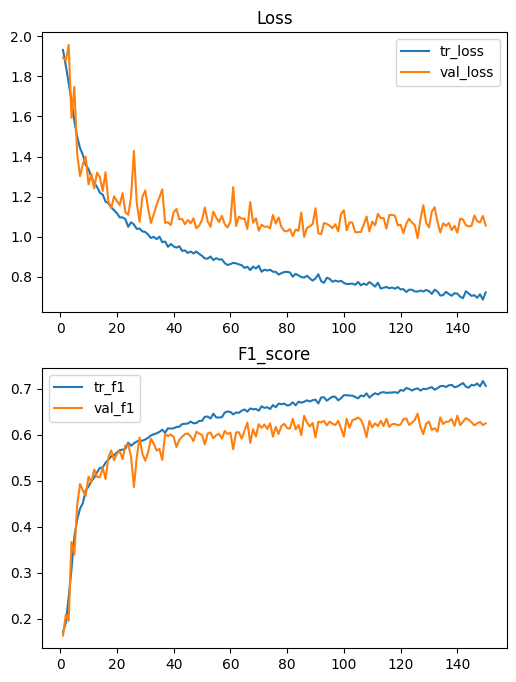

In [ ]:
# plot the learning curve. 
plt.figure(figsize=(6,8))
ax = plt.subplot(2,1,1)
ax.title.set_text('Loss')
sns.lineplot(x=range(1,epochs+1),y=history.history['loss'],label='tr_loss')
sns.lineplot(x=range(1,epochs+1),y=history.history['val_loss'],label='val_loss')
ax.legend()
ax = plt.subplot(2,1,2)
ax.title.set_text('F1_score')
sns.lineplot(x=range(1,epochs+1),y=history.history['f1_score'],label='tr_f1')
sns.lineplot(x=range(1,epochs+1),y=history.history['val_f1_score'],label='val_f1');


From the learning curve, we can see that our model is starting to overfit on the training data, from around epoch 80 the training and validation loss and score started to diverge.

In [ ]:
model = keras.models.load_model('./best_model2')

2023-05-10 15:23:59.933313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:23:59.943539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:23:59.944135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:23:59.945989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:23:59.946543: I tensorflow/compile

In [ ]:
# load the testing data to evaluate the performance of the selected model.
test_images_dir = './data/facial-expression-dataset/test/test'
test_dataset = keras.utils.image_dataset_from_directory(test_images_dir,image_size=(48,48),
                      color_mode='grayscale',label_mode='categorical',
                      batch_size=32,shuffle=False)
pred_target = model.predict(test_dataset)

Found 7178 files belonging to 7 classes.
  2/225 [..............................] - ETA: 23s

2023-05-10 15:29:59.269598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-05-10 15:29:59.269923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]


225/225 [==============================] - 2s 10ms/step


In [ ]:
# the issue is here.
true_labels = np.array([])
for x,y in test_dataset:
    true_labels = np.concatenate([true_labels,np.argmax(y.numpy(),axis=1)])
pred_labels = np.argmax(pred_target,axis=1)
true_labels.shape,pred_labels.shape

((7178,), (7178,))

In [ ]:
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

         0.0       0.25      0.08      0.12       958
         1.0       0.03      0.56      0.05       111
         2.0       0.18      0.11      0.14      1024
         3.0       0.35      0.05      0.08      1774
         4.0       0.21      0.07      0.10      1233
         5.0       0.26      0.18      0.22      1247
         6.0       0.26      0.74      0.38       831

    accuracy                           0.18      7178
   macro avg       0.22      0.25      0.16      7178
weighted avg       0.26      0.18      0.16      7178



From the above table we can see that the recall in disgust is 55%, but the precision is 2%, this caused by the high weight we gave the disgust class, which causes it to be 9 time more important then the other classes. The highest precision is happy class, the model seemed to learn the features that distingushe it from the other classses, which is not supprising as it has 7000 samples. Surprise class has the highest recall but very low percision, this require more invistgation to find why this happend.

<Figure size 800x800 with 0 Axes>

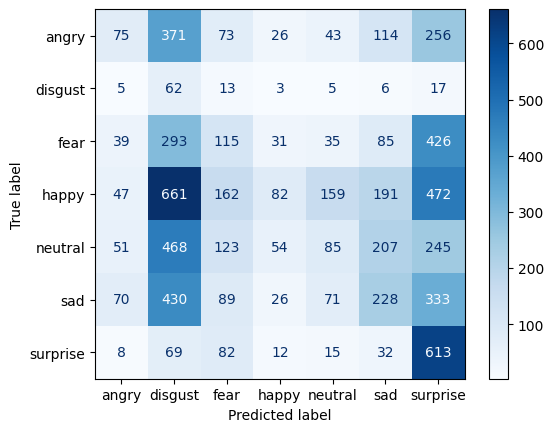

In [ ]:
# plotting the confusion matrix
fig = plt.figure(figsize=(8,8))
cm = confusion_matrix(y_true=true_labels,y_pred=pred_labels)
cmd = ConfusionMatrixDisplay(cm,display_labels=test_dataset.class_names)
cmd.plot(cmap=plt.cm.Blues);


The happy class is the heighest missclassified class caused by its small weight '0.5', 

In [ ]:
pred_correctness = pd.DataFrame({'true_labels':true_labels,'pred_labels':pred_labels})
pred_correctness['is_correct'] = true_labels == pred_labels
pred_correctness.true_labels = pred_correctness.true_labels.apply(lambda x: test_dataset.class_names[int(x)])
pred_correctness.pred_labels = pred_correctness.pred_labels.apply(lambda x: test_dataset.class_names[int(x)])
pred_correctness = pred_correctness.sample(frac=1)

In [ ]:
# display samples of each target class.
def ploting_results(df,base_dir):
    n_cols = 8
    n_rows = 5
    index = 1
    plt.figure(figsize=(1.5*n_cols,1.2*n_rows))
    plt.subplots_adjust(top=1.6,right=1.2)
    for record in df.iterrows():
        plt.subplot(5,8,index)
        
        img = plt.imread(test_dataset.file_paths[record[0]])
        plt.imshow(img,cmap=plt.cm.gray)
        plt.axis('off')
        index+=1
        plt.title(record[1][0]+'->'+record[1][1])
   

        

### Misclassified samples

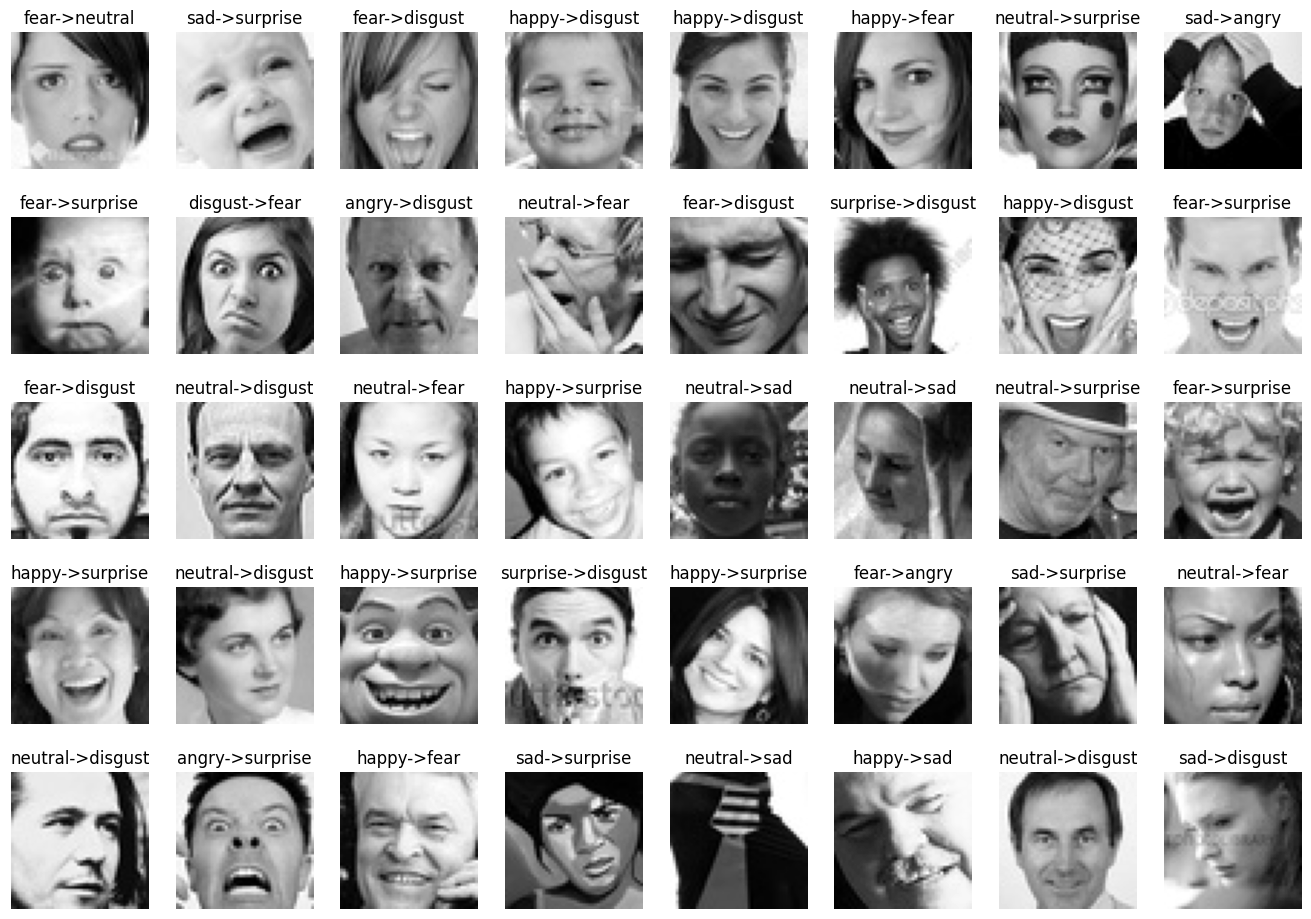

In [ ]:
# correct class -> prediction
ploting_results(pred_correctness[pred_correctness.is_correct == False].iloc[:40],test_images_dir)

Using weights is probably not the best option for this problem, since we care about the correct classification of all classes equally. However the data seem to contains wrong true labels, we can see it here also.  

### Correctly classified samples

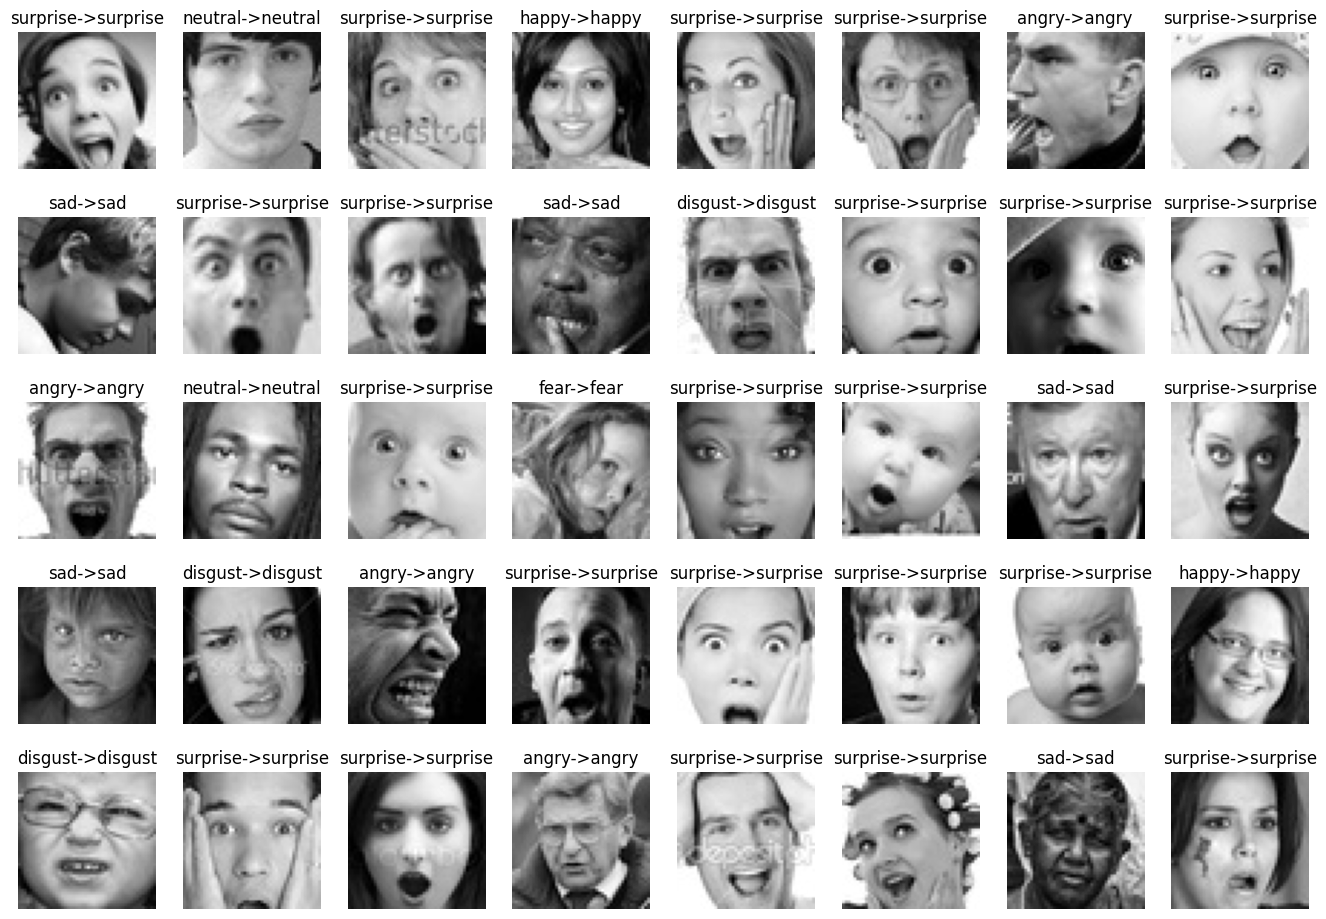

In [ ]:
ploting_results(pred_correctness[pred_correctness.is_correct == True].iloc[:40],test_images_dir)

Future work:
- Learning rate scheduler is better then a fixed value.  
- Automated Hyperparameters tuning algorithms like bayesian optimization or grid search, would have been better then the random search.
- Use cross validation to ensure the robustness of the model. 
- We can try handling the imbalanced data, by drawing equal random samples from each class for every epoach, so in every epoach the model will see the same minor samples but different samples of the major classes. Or try downsampling and oversampling to deal with the data imbalance. 